# Evolution du bruit médian en France depuis le début de la pandémie

> Ce Notebook présente lévolution du bruit médian en France depuis lde début de l'épidémie

---
## Importation des modules

In [1]:
%matplotlib inline

import datetime
import os
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import tqdm.notebook as tqdm
import warnings
from scipy import optimize
from scipy.signal import hilbert

try:
    os.environ["PROJ_LIB"] = r'/home/flavien/anaconda3/envs/SeismicNoise2A/share/basemap/'
except:
    pass
from mpl_toolkits.basemap import Basemap


from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.client import FDSNNoDataException
from obspy.signal import PPSD

%load_ext autoreload
%autoreload 2
from seismic_noise import *
import seismosocialdistancing

---
## Paramètre initiaux

In [2]:
PPSD_FOLDER  = "/media/flavien/Flavien USB/Stages/noise_data/PPSD"
DRMS_FOLDER  = "/media/flavien/Flavien USB/Stages/noise_data/DRMS"
MSEED_FOLDER = "/media/flavien/Flavien USB/Stages/noise_data/MSEED"
DATA_FOLDER  = "DATA"
freqs = [(0.01, 0.03), (0.1, 0.25), (0.3, 1), (1, 3), (5, 15), (20, 50)] # Bandes de fréquences à étudier
freq = "5.0-15.0"

tStart = "2020-01-01"
tEnd   = "2021-08-01"
year_ref = 2019

# list_stations = ["FR.STR.00.HHZ", "FR.CURIE.00.HHZ", "FR.BRGF.00.HHZ"]
list_stations = np.loadtxt(DATA_FOLDER + "/st_metadata/stations_fr.txt", dtype=str)
list_stations = ["FR.TRBF.00.HHZ"]

In [3]:
tags = {
    "2020-03-17": "Lockdown 1",
    "2020-05-11": "End lockdown",
    "2020-10-30": "Lockdown 2",
    "2020-12-15": "End lockdown + Curfew 20h",
    "2020-12-25": "Christmas",
    "2021-01-01": "New Year",
    "2021-01-16": "Curfew 18h",
    "2021-03-20": "Curfew 19h",
    "2021-04-03": "Lockdown 3",
    "2021-05-03": "End of certificate",
    "2021-05-19": "Curfew 21h + Shops open",
    "2021-06-09": "Curfew 23h + Restaurants open",
    "2021-06-30": "End Curfew"
}
dates_tags = pd.to_datetime(([key for key in tags.keys()]))
desc_tags = [(value) for value in tags.values()]

---
## Médiane à toutes les stations

#### Calcul de la médiane pour chaque station

On calcul les PPSDs sur l'ensemble des périodes d'un mois (1 mois pendant le confinement, 1 mois hors confinement). Toutes les données sont stockées dans le dictionnaire `ppsds`.

In [4]:
tStart = pd.Timestamp(tStart)
tEnd = pd.Timestamp(tEnd)
nDays = (tEnd - tStart).days
dates = pd.date_range(tStart, periods=nDays, freq="D")
dfDates = pd.DataFrame(index=dates)

0it [00:00, ?it/s]

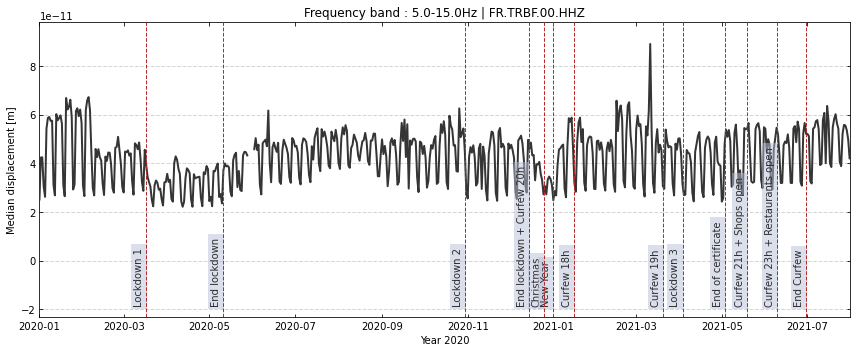

1it [00:00,  2.71it/s]


In [5]:
med_values = []
st_list = []

for j, st_str in tqdm.tqdm(enumerate(list_stations)):
    # name = "{}_{}_{}".format(st_str, str(periods[i][0])[:10], str(periods[i][1])[:10])

    ### Calcul du déplacement RMS de la station
    try:
        dataframe = pd.read_csv("{}/{}.csv".format(DRMS_FOLDER, st_str), index_col=0)
        dataframe.index=pd.to_datetime(dataframe.index)
        dRMS = dataframe
    except:
        continue
        
    st_list = np.append(st_list, st_str)  
    
    ### Conversion heures locales
    dRMS = dRMS.copy().tz_localize("UTC").tz_convert("Europe/Brussels").tz_localize(None).resample("30Min").mean()
        
    ### On garde les données dans la période temporelle qui nous intéresse
    # dRMS de référence (2019)
    mask_ref = (dRMS.index > pd.Timestamp("2019-01-01")) & (dRMS.index <= pd.Timestamp("2020-01-01"))
    dRMS_ref = dRMS.loc[mask_ref]
    submask = (dRMS_ref.index > (tStart - pd.Timedelta("365 days"))) & (dRMS_ref.index <= (tEnd - pd.Timedelta("731 days")))
    dRMS_sub = dRMS_ref.loc[submask]
    dRMS_sub.index = dRMS_sub.index + pd.offsets.DateOffset(years=1)
    dRMS_2019 = pd.concat([dRMS_ref, dRMS_sub])
    
    # dRMS à comparer (2020-2021)
    mask_time = (dRMS.index > tStart) & (dRMS.index <= tEnd)
    dRMS = dRMS.loc[mask_time]
    
    ### Récupération du bruit
    dRMS_med = dRMS[freq].between_time("6:00", "16:00").resample("1D").median()
    dRMS_med = dfDates.join(dRMS_med, how='outer')
    

    ### Mise en graphique
    color = "#353535"
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.tick_params(direction="in", which="both", top=True, right=True)
    ax.set_title("Frequency band : {}Hz | {}".format(freq, st_str))
    ax.plot(dRMS_med, color=color, lw=2, zorder=3)
    plt.ylim(-1*np.nanquantile(dRMS_med, 0.01), 1.5*np.nanquantile(dRMS_med, 0.99))
    ax.set_xlim([dates[0], dates[-1]])
    ax.set_xlabel("Year 2020")
    ax.set_ylabel("Median displacement [m]")

    box_txt = dict(boxstyle="square",
               facecolor='#B7C0D8',
               edgecolor='none',
               alpha=0.5)

    for n in range(len(dates_tags)):
        t_search = dates_tags[n]
        desc_search = desc_tags[n]
        t_text = t_search - pd.Timedelta("5 days")
        ax.axvline(t_search, ls="--", lw=1, color="#B82A2A", zorder=10)   # Confinement 1
        ax.text(t_text, -0.8*np.nanquantile(dRMS_med, 0.01), desc_search,
                color="#2B2B2B", fontsize="medium", rotation=90,
                ha="center", va="bottom",
                bbox=box_txt)   # Confinement 1

    plt.grid(axis="y", color="#D5D5D5", linestyle='--', linewidth=1)
    plt.tight_layout()
    # plt.savefig("RESULTS/FR_2020/noise_stations/{}_{}.png".format(st_str, freq), dpi=300)
    plt.show()
    # plt.close()
    # plt.clf()

    ### Normalisation du bruit
    dRMS_med = dRMS_med[freq].tolist()
    # norm = np.nanmedian(dRMS_med)
    # dRMS_med = dRMS_med/norm
    med_values.append(dRMS_med)

In [6]:
dRMS_2019

,0.0-0.0,0.1-0.2,0.3-1.0,1.0-3.0,5.0-15.0,20.0-50.0
2019-01-01 01:00:00,1.463056e-08,2.212443e-07,4.709962e-08,9.007168e-10,2.285806e-11,9.545236e-12
2019-01-01 01:30:00,1.689895e-08,2.195676e-07,4.495910e-08,8.931207e-10,2.331173e-11,9.540623e-12
2019-01-01 02:00:00,1.850543e-08,2.197526e-07,4.384884e-08,9.100607e-10,2.308273e-11,9.147019e-12
2019-01-01 02:30:00,1.453727e-08,2.218401e-07,4.356172e-08,9.086741e-10,2.280969e-11,9.161140e-12
2019-01-01 03:00:00,1.383092e-08,2.288760e-07,4.236026e-08,9.059412e-10,2.322087e-11,9.202126e-12
...,...,...,...,...,...,...
2020-07-31 22:00:00,5.530796e-08,5.618668e-08,2.125114e-08,5.638299e-10,2.705791e-11,9.822974e-12
2020-07-31 22:30:00,4.708149e-08,5.427861e-08,2.080442e-08,5.637595e-10,2.422466e-11,9.339806e-12
2020-07-31 23:00:00,3.695113e-08,5.555535e-08,2.085956e-08,5.510980e-10,2.323279e-11,9.196691e-12
2020-07-31 23:30:00,3.372133e-08,5.465870e-08,2.094569e-08,5.349424e-10,2.290788e-11,9.242851e-12


In [7]:
ii = 1
noise_2019  = dRMS_2019[freq].resample("1D").median()[1:].tolist()

# Retrait du 01/01/2019 pour se recaler sur un lundi en 2020
del noise_2019[364]
ii += 1

# Retrait du 29 février qui n'existe pas en 2019 pour ne pas être décalé d'un jour calendaire
del noise_2019[422]
ii += 1

noise_2019 = np.asarray(noise_2019)
noise_covid = np.asarray(dRMS[freq].resample("1D").median()[:-ii].tolist())
dates_diff  = dRMS.resample("1D").median()[:-ii].index
data_diff   = (noise_covid-noise_2019)/noise_2019 * 100

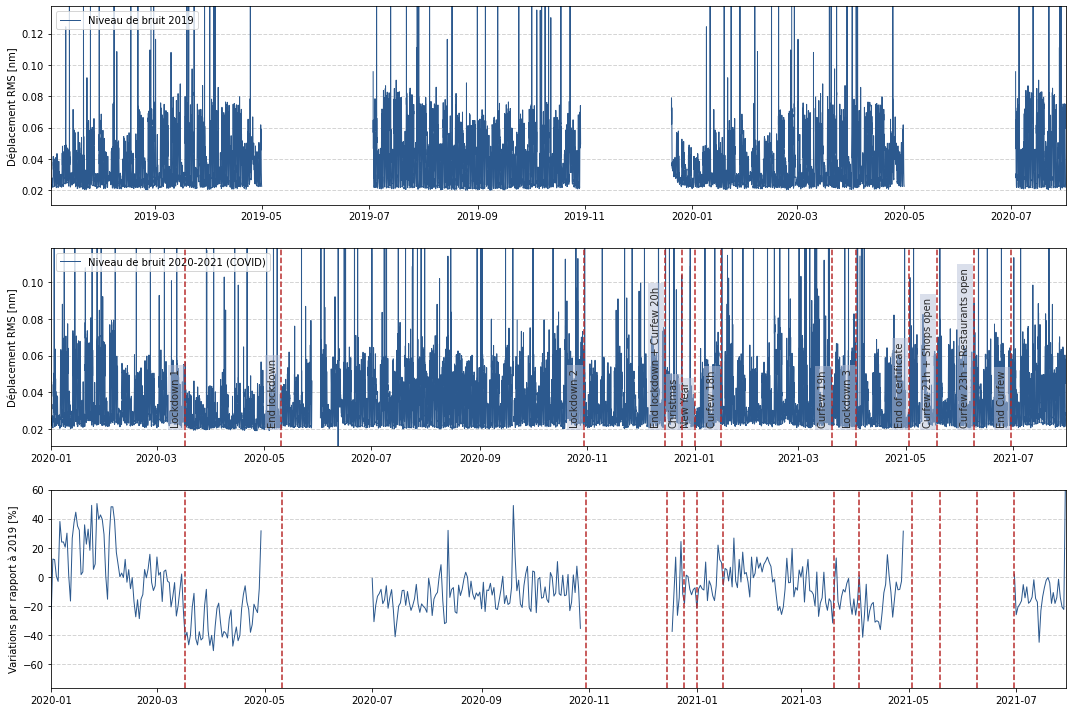

In [20]:
box_txt = dict(boxstyle="square",
               facecolor='#B7C0D8',
               edgecolor='none',
               alpha=0.5)

plt.figure(figsize=(15, 10))

plt.subplot(313)
plt.plot(dates_diff, data_diff, color="#2C598E", lw=1)
plt.ylim(2*np.nanquantile(data_diff, 0.05), 2*np.nanquantile(data_diff, 0.95))
plt.xlim(dates_diff[0], dates_diff[-1])
plt.grid(axis="y", color="#D5D5D5", linestyle='--', linewidth=1)
plt.ylabel("Variations par rapport à 2019 [%]")

for n in range(len(dates_tags)):
    t_search = dates_tags[n]
    desc_search = desc_tags[n]
    t_text = t_search - pd.Timedelta("5 days")
    plt.axvline(t_search, ls="--", lw=1.5, color="#B82A2A", zorder=10)   # Confinement 1


plt.subplot(312)
plt.plot(dRMS[freq]*1e9, color="#2C598E", lw=1)
plt.ylim(0.5*np.nanquantile(dRMS[freq]*1e9, 0.05), 2*np.nanquantile(dRMS[freq]*1e9, 0.95))
plt.xlim(dates[0], dates[-1])
plt.grid(axis="y", color="#D5D5D5", linestyle='--', linewidth=1)
plt.legend(["Niveau de bruit 2020-2021 (COVID)"], loc=2)
plt.ylabel("Déplacement RMS [nm]")

for n in range(len(dates_tags)):
    t_search = dates_tags[n]
    desc_search = desc_tags[n]
    t_text = t_search - pd.Timedelta("5 days")
    plt.axvline(t_search, ls="--", lw=1.5, color="#B82A2A", zorder=10)   # Confinement 1
    plt.text(t_text, 1*np.nanquantile(dRMS[freq]*1e9, 0.05), desc_search,
            color="#2B2B2B", fontsize="medium", rotation=90,
            ha="center", va="bottom",
            bbox=box_txt)   # Confinement 1
    
    
plt.subplot(311)
plt.plot(dRMS_2019[freq]*1e9, color="#2C598E", lw=1)
plt.ylim(0.5*np.nanquantile(dRMS_2019[freq]*1e9, 0.05), 2*np.nanquantile(dRMS_2019[freq]*1e9, 0.95))
plt.xlim(dRMS_2019.index[0], dRMS_2019.index[-1])
plt.grid(axis="y", color="#D5D5D5", linestyle='--', linewidth=1)
plt.legend(["Niveau de bruit 2019"], loc=2)
plt.ylabel("Déplacement RMS [nm]")

plt.tight_layout()

plt.savefig("results/var_STR_2019_COVID.png", dpi=300)